In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
vehicles = pd.read_csv('vehicles.csv')

c:\users\greg\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (70,71,72,73,74,76,79) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
select_columns = ['make', 'model', 'year', 'displ', 'cylinders', 'trany',
                 'drive', 'VClass', 'fuelType', 'barrels08', 'city08', 'highway08',
                 'comb08', 'co2TailpipeGpm', 'fuelCost08']

vehicles = vehicles[select_columns][vehicles.year <= 2016].drop_duplicates().dropna()

vehicles = vehicles.sort_values(['make', 'model', 'year'])

In [4]:
vehicles.columns = ['Make','Model','Year','Engine Displacement','Cylinders',
                    'Transmission','Drivetrain','Vehicle Class','Fuel Type',
                    'Fuel Barrels/Year','City MPG','Highway MPG','Combined MPG',
                    'CO2 Emission Grams/Mile','Fuel Cost/Year']

In [5]:
def unique_col_values(df):
    for column in df:
        print("{} | {} | {}".format(
            df[column].name, len(df[column].unique()), df[column].dtype
        ))

unique_col_values(vehicles)

Make | 126 | object
Model | 3490 | object
Year | 33 | int64
Engine Displacement | 65 | float64
Cylinders | 9 | float64
Transmission | 44 | object
Drivetrain | 7 | object
Vehicle Class | 34 | object
Fuel Type | 13 | object
Fuel Barrels/Year | 116 | float64
City MPG | 48 | int64
Highway MPG | 49 | int64
Combined MPG | 46 | int64
CO2 Emission Grams/Mile | 550 | float64
Fuel Cost/Year | 55 | int64


In [7]:
automatic = 'Automatic'
manual = 'Manual'

vehicles.loc[vehicles['Transmission'].str.startswith('A'),
            'Transmission Type'] = automatic

vehicles.loc[vehicles['Transmission'].str.startswith('M'),
            'Transmission Type'] = manual

In [8]:
small = ['Compact Cars','Subcompact Cars','Two Seaters','Minicompact Cars']
midsize = ['Midsize Cars']
large = ['Large Cars']

vehicles.loc[vehicles['Vehicle Class'].isin(small), 
             'Vehicle Category'] = 'Small Cars'

vehicles.loc[vehicles['Vehicle Class'].isin(midsize), 
             'Vehicle Category'] = 'Midsize Cars'

vehicles.loc[vehicles['Vehicle Class'].isin(large), 
             'Vehicle Category'] = 'Large Cars'

vehicles.loc[vehicles['Vehicle Class'].str.contains('Station'), 
             'Vehicle Category'] = 'Station Wagons'

vehicles.loc[vehicles['Vehicle Class'].str.contains('Truck'), 
             'Vehicle Category'] = 'Pickup Trucks'

vehicles.loc[vehicles['Vehicle Class'].str.contains('Special Purpose'), 
             'Vehicle Category'] = 'Special Purpose'

vehicles.loc[vehicles['Vehicle Class'].str.contains('Sport Utility'), 
             'Vehicle Category'] = 'Sport Utility'

vehicles.loc[(vehicles['Vehicle Class'].str.lower().str.contains('van')),
             'Vehicle Category'] = 'Vans & Minivans'

In [9]:
vehicles['Model Type'] = (vehicles['Make'] + " " +
                          vehicles['Model'].str.split().str.get(0))

In [11]:
vehicles['Fuel Type'].unique()

array(['Regular', 'Premium', 'Diesel', 'Premium and Electricity',
       'Premium or E85', 'Premium Gas or Electricity', 'Gasoline or E85',
       'Gasoline or natural gas', 'CNG', 'Regular Gas or Electricity',
       'Midgrade', 'Regular Gas and Electricity', 'Gasoline or propane'],
      dtype=object)

In [12]:
vehicles['Gas'] = 0
vehicles['Ethanol'] = 0
vehicles['Electric'] = 0
vehicles['Propane'] = 0
vehicles['Natural Gas'] = 0

vehicles.loc[vehicles['Fuel Type'].str.contains(
        'Regular|Gasoline|Midgrade|Premium|Diesel'),'Gas'] = 1

vehicles.loc[vehicles['Fuel Type'].str.contains('E85'),'Ethanol'] = 1

vehicles.loc[vehicles['Fuel Type'].str.contains('Electricity'),'Electric'] = 1

vehicles.loc[vehicles['Fuel Type'].str.contains('propane'),'Propane'] = 1

vehicles.loc[vehicles['Fuel Type'].str.contains('natural|CNG'),'Natural Gas'] = 1

In [13]:
vehicles.loc[vehicles['Fuel Type'].str.contains(
        'Regular|Gasoline'),'Gas Type'] = 'Regular'

vehicles.loc[vehicles['Fuel Type'] == 'Midgrade',
             'Gas Type'] = 'Midgrade'

vehicles.loc[vehicles['Fuel Type'].str.contains('Premium'),
             'Gas Type'] = 'Premium'

vehicles.loc[vehicles['Fuel Type'] == 'Diesel',
             'Gas Type'] = 'Diesel'

vehicles.loc[vehicles['Fuel Type'].str.contains('natural|CNG'),
             'Gas Type'] = 'Natural'

In [14]:
efficiency_categories = ['Very Low Efficiency', 'Low Efficiency',
                         'Moderate Efficiency','High Efficiency',
                         'Very High Efficiency']

vehicles['Fuel Efficiency'] = pd.qcut(vehicles['Combined MPG'],
                                      5, efficiency_categories)

engine_categories = ['Very Small Engine', 'Small Engine','Moderate Engine', 'Large Engine', 'Very Large Engine']

vehicles['Engine Size'] = pd.qcut(vehicles['Engine Displacement'],
                                  5, engine_categories)

emission_categories = ['Very Low Emissions', 'Low Emissions',
                        'Moderate Emissions','High Emissions',
                        'Very High Emissions']

vehicles['Emissions'] = pd.qcut(vehicles['CO2 Emission Grams/Mile'],
                                 5, emission_categories)

fuelcost_categories = ['Very Low Fuel Cost', 'Low Fuel Cost',
                       'Moderate Fuel Cost','High Fuel Cost',
                       'Very High Fuel Cost']

vehicles['Fuel Cost'] = pd.qcut(vehicles['Fuel Cost/Year'],
                                5, fuelcost_categories)

In [15]:
cluster_columns = ['Engine Displacement','Cylinders','Fuel Barrels/Year', 'City MPG','Highway MPG','Combined MPG', 'CO2 Emission Grams/Mile', 'Fuel Cost/Year']

In [16]:
from sklearn import preprocessing
scaler = preprocessing.MaxAbsScaler()

vehicle_clusters = scaler.fit_transform(vehicles[cluster_columns])
vehicle_clusters = pd.DataFrame(vehicle_clusters, columns=cluster_columns)

In [17]:
from sklearn.cluster import KMeans

def kmeans_cluster(df, n_clusters=2):
    model = KMeans(n_clusters=n_clusters, random_state=1)
    clusters = model.fit_predict(df)
    cluster_results = df.copy()
    cluster_results['Cluster'] = clusters
    return cluster_results

In [18]:
def summarize_clustering(results):
    cluster_size = results.groupby(['Cluster']).size().reset_index()
    cluster_size.columns = ['Cluster', 'Count']
    cluster_means = results.groupby(['Cluster'], as_index=False).mean()
    cluster_summary = pd.merge(cluster_size, cluster_means, on='Cluster')
    return cluster_summary

In [19]:
cluster_results = kmeans_cluster(vehicle_clusters, 8)
cluster_summary = summarize_clustering(cluster_results)

In [22]:
print(cluster_summary)

   Cluster  Count  Engine Displacement  Cylinders  Fuel Barrels/Year  \
0        0   6334             0.241518   0.254243           0.281230   
1        1   2912             0.595553   0.500215           0.395664   
2        2   3999             0.631932   0.501500           0.495338   
3        3   5838             0.267466   0.253950           0.346015   
4        4   7704             0.382627   0.374854           0.353653   
5        5   1826             0.200601   0.244660           0.215546   
6        6   4766             0.446931   0.373387           0.437697   
7        7   1716             0.682005   0.570950           0.601364   

   City MPG  Highway MPG  Combined MPG  CO2 Emission Grams/Mile  \
0  0.383366     0.487341      0.447303                 0.281191   
1  0.262860     0.360903      0.315677                 0.400217   
2  0.218378     0.281825      0.255475                 0.495517   
3  0.314615     0.392238      0.363536                 0.345953   
4  0.297454     

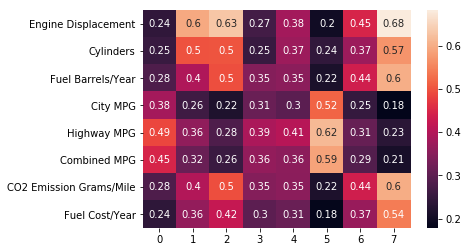

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(cluster_summary[cluster_columns].transpose(), annot=True)

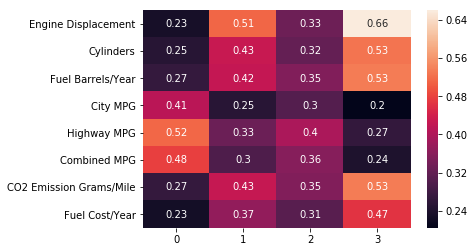

In [24]:
cluster_results = kmeans_cluster(vehicle_clusters, 4)
cluster_summary = summarize_clustering(cluster_results)

sns.heatmap(cluster_summary[cluster_columns].transpose(), annot=True)